### Parameter recovery code - in orientation to: 
https://github.com/hcp4715/dockerHDDM/blob/master/dockerHDDMTutorial/Parameter_recovery.ipynb

### this is code for the parameter recovery of the combined (LEESEE) model

In [ ]:
%matplotlib inline

# scitnific computing and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr
import statsmodels.api as sm

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC3
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


- model for ES and EE: 
v_reg = {'model': 'v ~ 1 + AttentionW + InattentionW:C(OVcate)', 'link_func': lambda x: x}
reg_descr = [v_reg]
depends_on = {'t': 'OVcate'}
- at the group level: a, AttentionW, intercept

- model for ESEE:

v_reg = {'model': 'v ~ 1 + AttentionW + InattentionW:C(phase)', 'link_func': lambda x: x}
reg_descr = [v_reg]
depends_on = {'t': 'phase'}
- at the group level: a, AttentionW, intercept

### reg_plot_with_corr does this: It plots a scatterplot with a regression line, and annotates the plot with:

- Pearson correlation coefficient (r)

- p-value

- Regression intercept (β₀)

- Regression slope (β₁)

In [ ]:
# paths
model_dir = "/home/jovyan/OfficialTutorials/THESIS_HDDM/model_dir_garcia_CCT_2"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


chain0 = az.from_netcdf("/home/jovyan/OfficialTutorials/THESIS_HDDM/model_dir_garcia_CCT_2/garcia_replication_LEESEE_5_0.nc")
chain1 = az.from_netcdf("/home/jovyan/OfficialTutorials/THESIS_HDDM/model_dir_garcia_CCT_2/garcia_replication_LEESEE_5_1.nc")
chain2 = az.from_netcdf("/home/jovyan/OfficialTutorials/THESIS_HDDM/model_dir_garcia_CCT_2/garcia_replication_LEESEE_5_2.nc")

leesee5_infdata = az.concat([chain0, chain1], dim="chain")


In [ ]:
def regplot_with_corr(
    data=None,
    x="x",
    y="y",
    cor_anonot=True,
    reg_anonot=True,
    annot_kws={
        "fontsize": 8,
        "xy": (0.95, 0.05),
        "ha": 'right',
        "va": 'bottom'
    },
    scatter_kws={
        's': 40,
        "alpha": 0.4
    },
    ax=None,
    **kwargs
):
    """

    Example:
    --------
    >>> Example usage
    >>> import pandas as pd
    >>> data = pd.DataFrame({'x': [1, 2, 3, 4, 5], 'y': [2, 3, 5, 7, 11]})
    >>> regplot_with_corr(data)
    >>> plt.show()
    """
    if ax is None:
        ax = plt.gca()
    if data is not None:
        data_x = data[x]
        data_y = data[y]
    else: 
        data_x = x
        data_y = y

    # Plot regression line and scatter plot
    sns.regplot(
        x=data_x,
        y=data_y,
        ci=None if len(np.unique(data_y)) == 1 else 95,
        scatter_kws=scatter_kws,
        ax=ax
    )

    annot_text = ""
    if cor_anonot:
        # Calculate Pearson correlation
        correlation, p_value = pearsonr(data_x, data_y)
        # if np.isnan(correlation):
        #     correlation = 0
        # if np.isnan(p_value):
        #     p_value = 1
        p_str = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.3f}"
        annot_text += f"$r={correlation:.2f}$\n${p_str}$"

    if reg_anonot:
        # Calculate regression coefficients
        X = sm.add_constant(data_x)  # Adds a constant term to the predictor
        model = sm.OLS(data_y, X).fit()
        intercept, slope = model.params
        annot_text += f"\n$\\beta_0={intercept:.2f}$\n$\\beta_1={slope:.2f}$"

    # Annotate the plot with correlation, p-value, intercept, and slope
    if annot_text != "":
        ax.annotate(
            annot_text,
            **annot_kws,
            xycoords='axes fraction',
            bbox=dict(
                boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'
            )
        )
    
    return ax


def az_summary(infdata=None, half_a=False, param_names_order=None, **kwargs):

    param_df = az.summary(infdata, kind="stats",
                            **kwargs).reset_index(names="param_name")
    # col_values = ['mean', 'sd', "hdi_3%", "hdi_97%"]
    col_values = list(param_df.columns[1:5])

    pattern = r'(.*)_subj\.(\d+)'

    param_df[['param',
                'subj_idx']] = param_df['param_name'].str.extract(pattern)
    # param_df['param'] = param_df['param'].apply(lambda x: f'${x}$')
    param_df = param_df.dropna(subset=['subj_idx'])
    param_df['subj_idx'] = param_df['subj_idx'].astype(int)

    if half_a:
        param_df.loc[param_df['param'] == 'a',
                        col_values] = param_df.loc[param_df['param'] == 'a',
                                                col_values] / 2

    param_df = param_df.pivot(
        index='subj_idx', columns='param', values=col_values
    )

    if param_names_order is not None:
        new_index = pd.MultiIndex.from_tuples(
            [
                (level_0, param) for level_0 in col_values
                for param in param_names_order
            ],
            names=[None, 'param']
        )
        param_df = param_df.reindex(columns=new_index)

    param_df.reset_index(inplace=True)
    param_df.columns.names = [None, None]

    return param_df

In [4]:
summary_df = az_summary(leesee5_infdata)['mean']
print(summary_df.columns.tolist())


['a', 'v_AttentionW', 'v_InattentionW:C(phase)[EE]', 'v_InattentionW:C(phase)[ES]', 'v_InattentionW:C(phase)[LE]', 'v_Intercept']


In [6]:
leesee5_infdata


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

In [ ]:
# load
data_LEESEE_5 =leesee5_infdata.observed_data.to_dataframe().reset_index(drop=True)

df_ind_summary = data_LEESEE_5.groupby(['subj_idx','phase'])['rt'].describe().reset_index()
df_ind_summary = df_ind_summary.set_index('subj_idx').join(
     az_summary(leesee5_infdata)['mean'].reset_index(names=['subj_idx']).set_index('subj_idx')
     ).reset_index()
df_ind_summary.head()

,subj_idx,phase,count,mean,std,min,25%,50%,75%,max,a,v_AttentionW,v_InattentionW:C(phase)[EE],v_InattentionW:C(phase)[ES],v_InattentionW:C(phase)[LE],v_Intercept
0,2,EE,140.0,0.446615,0.666357,-1.943292,0.468510,0.554559,0.748629,1.872891,2.261,0.032,0.022,0.028,-0.044,0.641
1,2,ES,360.0,0.715587,0.942763,-4.674307,0.581514,0.752386,1.017121,4.797810,2.261,0.032,0.022,0.028,-0.044,0.641
2,2,LE,150.0,0.358153,0.539634,-2.949360,0.321348,0.390392,0.497430,2.768887,2.261,0.032,0.022,0.028,-0.044,0.641
3,3,EE,140.0,0.022279,2.395720,-26.960564,-0.497768,0.449853,0.578157,1.632821,1.589,0.045,0.034,0.041,-0.010,0.513
4,3,ES,356.0,0.400919,0.953963,-3.177080,0.397909,0.603289,0.814021,4.221122,1.589,0.045,0.034,0.041,-0.010,0.513


In [8]:
print(leesee5_infdata.groups())


['posterior', 'posterior_predictive', 'log_likelihood', 'observed_data']


In [ ]:
def az_summary_group(infdata, **kwargs):
    summary_df = az.summary(infdata, kind="stats", **kwargs).reset_index()
    param_col = 'index' if 'index' in summary_df.columns else 'param_name'
    return summary_df.set_index(param_col)["mean"]

In [ ]:
group_params = az_summary_group(leesee5_infdata)
print(group_params.index.tolist())


['a', 'a_std', 'a_subj.2', 'a_subj.3', 'a_subj.7', 'a_subj.8', 'a_subj.9', 'a_subj.10', 'a_subj.11', 'a_subj.12', 'a_subj.13', 'a_subj.15', 'a_subj.16', 'a_subj.17', 'a_subj.18', 'a_subj.19', 'a_subj.20', 'a_subj.21', 'a_subj.22', 'a_subj.23', 'a_subj.24', 'a_subj.25', 'a_subj.26', 't(EE)', 't(ES)', 't(LE)', 't_std', 't_subj(EE).2', 't_subj(EE).3', 't_subj(EE).7', 't_subj(EE).8', 't_subj(EE).9', 't_subj(EE).10', 't_subj(EE).11', 't_subj(EE).12', 't_subj(EE).13', 't_subj(EE).15', 't_subj(EE).16', 't_subj(EE).17', 't_subj(EE).18', 't_subj(EE).19', 't_subj(EE).20', 't_subj(EE).21', 't_subj(EE).22', 't_subj(EE).23', 't_subj(EE).24', 't_subj(EE).25', 't_subj(EE).26', 't_subj(ES).2', 't_subj(ES).3', 't_subj(ES).7', 't_subj(ES).8', 't_subj(ES).9', 't_subj(ES).10', 't_subj(ES).11', 't_subj(ES).12', 't_subj(ES).13', 't_subj(ES).15', 't_subj(ES).16', 't_subj(ES).17', 't_subj(ES).18', 't_subj(ES).19', 't_subj(ES).20', 't_subj(ES).21', 't_subj(ES).22', 't_subj(ES).23', 't_subj(ES).24', 't_subj(ES)

In [ ]:
group_params = az.summary(leesee5_infdata, var_names=['~subj', '~std'], filter_vars='regex')
subject_params = az_summary(leesee5_infdata)['mean']  

t_params = {}
for param in group_params.index:
    if param.startswith('t_subj'):
        parts = param.split(')')
        phase_level = parts[0].split('(')[1]
        subj_id = int(parts[1].split('.')[1])
        if subj_id not in t_params:
            t_params[subj_id] = {}
        t_params[subj_id][phase_level] = group_params.loc[param, 'mean']
    
sim_data = pd.DataFrame()

for (subj, phases), trial_group in data_LEESEE_5.groupby(['subj_idx','phase']):
    
    j = df_ind_summary[(df_ind_summary['subj_idx'] == subj) & (df_ind_summary['phase'] == phases)].iloc[0]
    
    a_val = j["a"]
    v_int = j["v_Intercept"]
    v_att = j["v_AttentionW"]
    v_inatt = j[f"v_InattentionW:C(phase)[{phases}]"]
    
    try:
        t_val = t_params[int(subj)][phases]
    except KeyError:
        t_val = group_params.loc[f't({phases})', 'mean']
    
    for idx, trial in trial_group.iterrows():
        att_val = trial["AttentionW"]      # trial-specific value
        inatt_val = trial["InattentionW"]    # trial-specific value
        
        # drift rate
        v_trial = v_int + v_att * att_val + v_inatt * inatt_val
        
        # single trial simulation
        sim_trial, _ = hddm.generate.gen_rand_data(
            {"v": v_trial, "a": a_val, "t": t_val},
            size=1,
            subjs=1,
        )
        sim_trial["subj_idx"] = subj
        sim_trial["phase"] = phases
        sim_trial["AttentionW"] = att_val
        sim_trial["InattentionW"] = inatt_val

        sim_data = pd.concat([sim_data, sim_trial], ignore_index=True)

if 'condition' in sim_data.columns:
    sim_data.drop('condition', axis=1, inplace=True)
print(sim_data.head(10))
print("\nUnique subjects in simulation:", sim_data['subj_idx'].nunique())
print("phase counts in simulation:\n", sim_data['phase'].value_counts())

print(sim_data.to_string())


      rt  response  subj_idx phase  AttentionW  InattentionW
0  0.975       1.0         2    EE      20.265        -0.265
1  0.966       1.0         2    EE      22.051        27.949
2  1.073       1.0         2    EE     -16.391        26.391
3  0.631       1.0         2    EE      10.467        -0.467
4  0.657       1.0         2    EE      39.064        20.936
5  1.818       1.0         2    EE     -41.129        61.129
6  0.517       1.0         2    EE      43.288         6.712
7  0.878       1.0         2    EE      14.662         5.338
8  0.986       1.0         2    EE      40.610         9.390
9  1.791       1.0         2    EE      16.224        -6.224

Unique subjects in simulation: 21
phase counts in simulation:
 phase
ES    7234
LE    3059
EE    2756
Name: count, dtype: int64
          rt  response  subj_idx phase  AttentionW  InattentionW
0      0.975       1.0         2    EE      20.265        -0.265
1      0.966       1.0         2    EE      22.051        27.949
2    

In [12]:
sim_data = sim_data[sim_data['subj_idx'] < 20]


In [13]:
print(sim_data[['subj_idx', 'phase', 'rt', 'response']].head())
print("\nUnique subjects:", sim_data['subj_idx'].nunique())
print("phase counts:\n", sim_data['phase'].value_counts())

   subj_idx phase     rt  response
0         2    EE  0.975       1.0
1         2    EE  0.966       1.0
2         2    EE  1.073       1.0
3         2    EE  0.631       1.0
4         2    EE  0.657       1.0

Unique subjects: 14
phase counts:
 phase
ES    4720
LE    1956
EE    1789
Name: count, dtype: int64


In [ ]:
sim_data = sim_data[sim_data['subj_idx'] < 20]


#if 'AttentionW' not in sim_data.columns:
#    sim_data['AttentionW'] = 1.0  # fixed (not doing it)
#if 'InattentionW' not in sim_data.columns:
#    sim_data['InattentionW'] = 1.0  # fixed (not doing it)

def run_sampling(model, model_db_name, progress_bar=True):
    model.find_starting_values()
    result = model.sample(
        300,                 
        burn=100,            
        dbname=model_db_name,
        db='pickle',         
        return_infdata=True, 
        loglike=True,
        ppc=True
    )
    if isinstance(result, tuple):
        model_out = result[0]
        infdata = result[1]
        return model_out, infdata
    else:
        return model, result

# ESEE model
v_reg = {'model': 'v ~ 1 + AttentionW + InattentionW:C(phase)', 'link_func': lambda x: x}
reg_descr = [v_reg]
depends_on = {'t': 'phase'}

m_recovery = hddm.HDDMRegressor(
    sim_data,              
    reg_descr,             
    depends_on=depends_on, 
    include=['a', 't', 'v'],  
    p_outlier=0.05,
    group_only_regressors=False,
    keep_regressor_trace=True
)

model_db_name = os.path.join(model_dir, "mLEESEE_5_recovery")

m_recovery, m_recovery_infdata = run_sampling(m_recovery, model_db_name, progress_bar=False)

az.to_netcdf(m_recovery_infdata, os.path.join(model_dir, "mLEESEE_5_recovery.nc"))


No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 301 of 300 complete in 249.9 sechddm sampling elpased time:  250.527 s
Start to calculate pointwise log likelihood...
The time of calculation of loglikelihood took 117.926 seconds
Start generating posterior prediction...
The time of generating PPC took 50.572 seconds
Start converting to InferenceData...


'/home/jovyan/OfficialTutorials/THESIS_HDDM/model_dir_garcia_CCT_2/mLEESEE_5_recovery.nc'

In [ ]:
# get recovered inferenceData from the .nc file
model_dir = "/home/jovyan/OfficialTutorials/THESIS_HDDM/model_dir_garcia_CCT_2"
recovered_nc = os.path.join(model_dir, "mLEESEE_5_recovery.nc")
m_recovery_infdata = az.from_netcdf(recovered_nc)


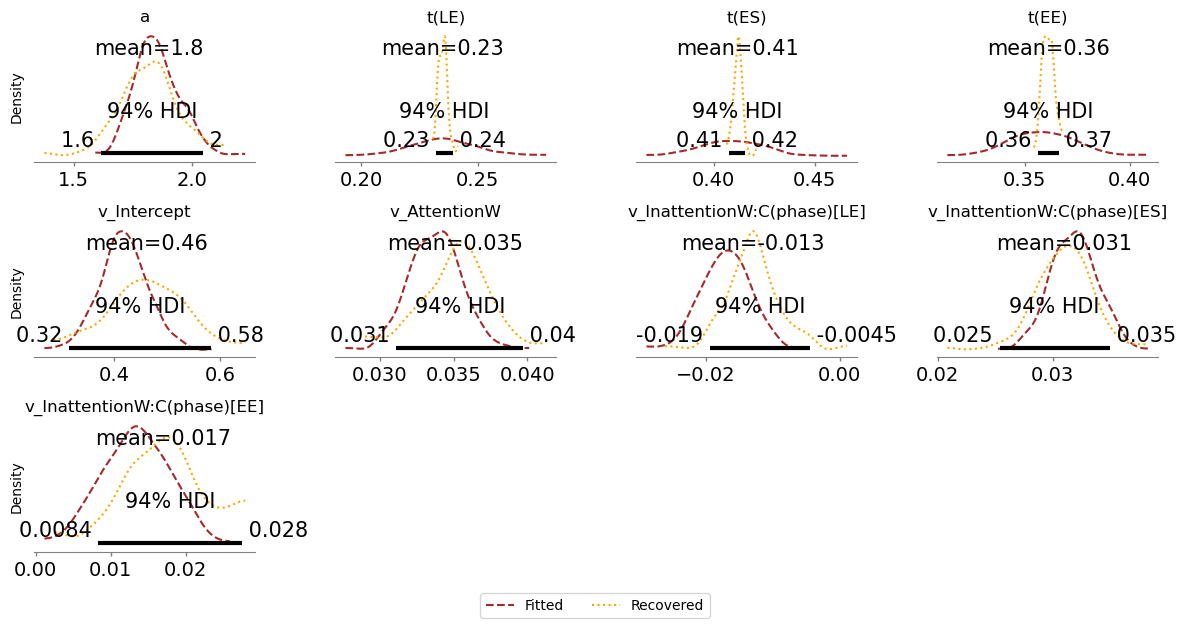

In [ ]:
param_list = [
    'a',
    't(LE)', 't(ES)','t(EE)',
    'v_Intercept',
    'v_AttentionW',
    'v_InattentionW:C(phase)[LE]',
    'v_InattentionW:C(phase)[ES]',
    'v_InattentionW:C(phase)[EE]',

]

n_params = len(param_list)
n_cols = 4
figsize = (12, 6)
n_rows = (n_params + n_cols - 1) // n_cols

f, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
ax = ax.flatten()

for i, param in enumerate(param_list):
    az.plot_posterior(
        leesee5_infdata.posterior[param],     # real data
        ax=ax[i],
        color="brown",
        linestyle="dashed",
        label="Fitted",
        hdi_prob='hide',
        point_estimate=None
    )
    az.plot_posterior(
        m_recovery_infdata.posterior[param],   # recovered data
        ax=ax[i],
        color="orange",
        linestyle="dotted",
        label="Recovered"
    )
    ax[i].set_ylabel('Density' if i % n_cols == 0 else '')
    ax[i].set_title(param)
    if i == 0:
        handles, labels = ax[0].get_legend_handles_labels()
    if ax[i].get_legend():
        ax[i].legend_.remove()

for j in range(i + 1, len(ax)):
    f.delaxes(ax[j])

f.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.tight_layout()
plt.show()

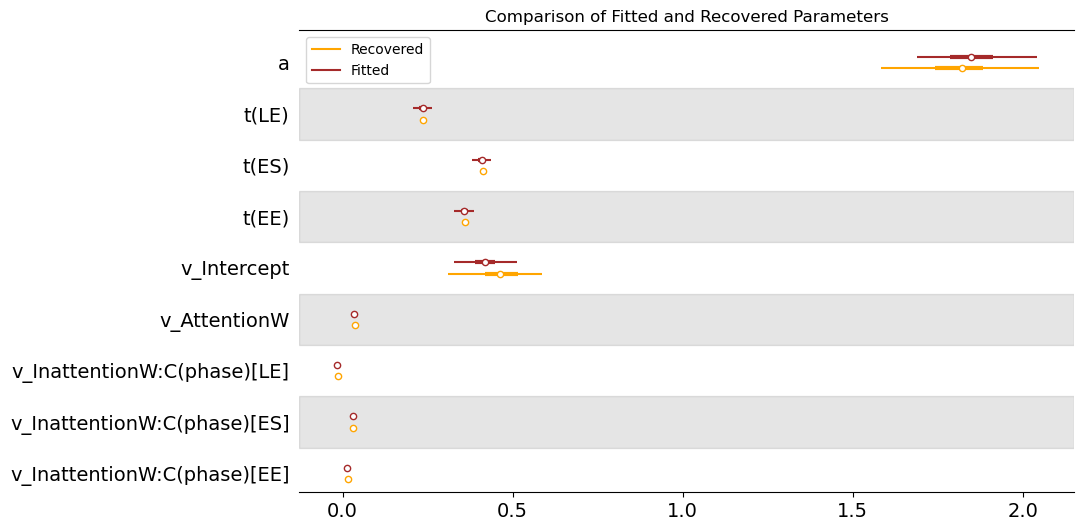

In [ ]:
# forest plot (group-level)
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_forest(
    [leesee5_infdata, m_recovery_infdata],
    model_names=["Fitted", "Recovered"],
    var_names=param_list,
    combined=True,
    ridgeplot_alpha=0.5,
    hdi_prob=0.95,
    colors=["brown", "orange"],  # <-- add this line!
    ax=ax
)
ax.set_title("Comparison of Fitted and Recovered Parameters")
plt.show()


In [ ]:
import arviz as az
import matplotlib.pyplot as plt

def hdi_overlap(idata1, idata2, var_name, hdi_prob=0.94):
    """
    Compute the percent overlap of the HDIs between two posterior distributions
    """
    hdi1 = az.hdi(idata1.posterior[var_name], hdi_prob=hdi_prob).to_array().values
    hdi2 = az.hdi(idata2.posterior[var_name], hdi_prob=hdi_prob).to_array().values
    lower1, upper1 = hdi1.min(), hdi1.max()
    lower2, upper2 = hdi2.min(), hdi2.max()
    overlap = max(0, min(upper1, upper2) - max(lower1, lower2))
    total_range = max(upper1, upper2) - min(lower1, lower2)
    return overlap / total_range if total_range > 0 else 0

param_list = [
    'a',
    't(ES)', 't(EE)',
    'v_Intercept',
    'v_AttentionW',
    'v_InattentionW:C(phase)[ES]',
    'v_InattentionW:C(phase)[EE]',
]

n_params = len(param_list)
n_cols = 4
figsize = (12, 6)
n_rows = (n_params + n_cols - 1) // n_cols

f, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
ax = ax.flatten()

hdi_results = []

for i, param in enumerate(param_list):
    try:
        az.plot_posterior(
            esee5_infdata.posterior[param],                  # fitted posterior
            ax=ax[i],
            color="grey",
            linestyle="dashed",
            label="Fitted",
            hdi_prob='hide',
            point_estimate=None
        )

        az.plot_posterior(
            m_recovery_infdata.posterior[param],            # recovered posterior
            ax=ax[i],
            color="orange",
            linestyle="dotted",
            label="Recovered"
        )

        ax[i].set_ylabel('Density' if i % n_cols == 0 else '')
        ax[i].set_title(param)

        hdi_ol = hdi_overlap(esee5_infdata, m_recovery_infdata, param)
        hdi_results.append((param, hdi_ol))
        ax[i].annotate(f"HDI overlap: {hdi_ol:.1%}", xy=(0.5, 0.9), xycoords='axes fraction',
                       ha='center', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

    except Exception as e:
        print(f"Could not process param '{param}': {e}")
        ax[i].axis('off')

for j in range(i + 1, len(ax)):
    f.delaxes(ax[j])

handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.tight_layout()
plt.show()

print("\n HDI Overlap Summary:")
for param, ol in hdi_results:
    print(f"{param:<40}: {ol:.1%} HDI overlap")


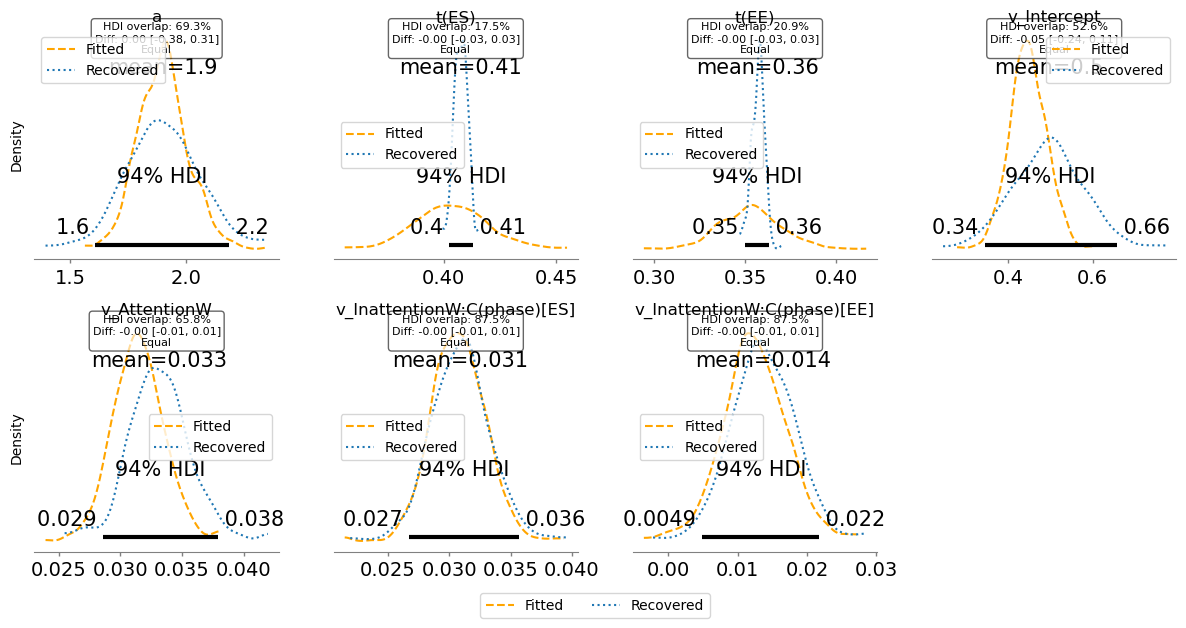

Summary exported to parameter_recovery_summary.csv
                     Parameter  HDI_Overlap               Diff_Mean   
0                            a     0.693331   0.0031945265378927647  \
1                        t(ES)     0.175000    -0.00352250349197729   
2                        t(EE)     0.208785   -0.003205250957080196   
3                  v_Intercept     0.526229   -0.049751984504993206   
4                 v_AttentionW     0.658235   -0.001656051564427657   
5  v_InattentionW:C(phase)[ES]     0.875066  -0.0001930105512424979   
6  v_InattentionW:C(phase)[EE]     0.875205   -0.001416682552021074   

   Diff_Lower  Diff_Upper  Equal  
0   -0.382518    0.305085   True  
1   -0.032297    0.030487   True  
2   -0.030683    0.030853   True  
3   -0.236640    0.113534   True  
4   -0.007113    0.005651   True  
5   -0.005893    0.005717   True  
6   -0.013787    0.009967   True  


In [ ]:

def hdi_overlap(idata1, idata2, var_name, hdi_prob=0.94):
    """
    Compute the percent overlap of the HDIs between two posterior distributions
    """
    hdi1 = az.hdi(idata1.posterior[var_name], hdi_prob=hdi_prob).to_array().values
    hdi2 = az.hdi(idata2.posterior[var_name], hdi_prob=hdi_prob).to_array().values
    lower1, upper1 = hdi1.min(), hdi1.max()
    lower2, upper2 = hdi2.min(), hdi2.max()
    overlap = max(0, min(upper1, upper2) - max(lower1, lower2))
    total_range = max(upper1, upper2) - min(lower1, lower2)
    return overlap / total_range if total_range > 0 else 0

def difference_hdi(idata1, idata2, var_name, hdi_prob=0.94):
    """
    Compute the posterior difference (fitted minus recovered) for a parameter,
    then calculate the mean difference and its HDI
    
    Returns:
        diff_mean: Mean difference
        diff_lower: Lower bound of the HDI
        diff_upper: Upper bound of the HDI
        equal: Boolean; True if the HDI includes 0 (interpreted as "Equal")
    """
    diff = idata1.posterior[var_name] - idata2.posterior[var_name]
    hdi_diff = az.hdi(diff, hdi_prob=hdi_prob).to_array().values
    lower, upper = hdi_diff.min(), hdi_diff.max()
    diff_mean = diff.mean().values
    equal = (lower <= 0) and (upper >= 0)
    return diff_mean, lower, upper, equal

param_list = [
    'a',
    't(ES)', 't(EE)',
    'v_Intercept',
    'v_AttentionW',
    'v_InattentionW:C(phase)[ES]',
    'v_InattentionW:C(phase)[EE]',
]

n_params = len(param_list)
n_cols = 4
figsize = (12, 6)
n_rows = (n_params + n_cols - 1) // n_cols

f, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
ax = ax.flatten()

summary_data = []

for i, param in enumerate(param_list):
    try:
        az.plot_posterior(
            esee5_infdata.posterior[param],
            ax=ax[i],
            color="orange",
            linestyle="dashed",
            label="Fitted",
            hdi_prob='hide',
            point_estimate=None
        )
        az.plot_posterior(
            m_recovery_infdata.posterior[param],
            ax=ax[i],
            linestyle="dotted",
            label="Recovered"
        )
        ax[i].set_ylabel('Density' if i % n_cols == 0 else '')
        ax[i].set_title(param)
        
        hdi_ol = hdi_overlap(esee5_infdata, m_recovery_infdata, param)
        diff_mean, diff_lower, diff_upper, equal = difference_hdi(esee5_infdata, m_recovery_infdata, param)
        equality_str = "Equal" if equal else "Not Equal"
        
        annotation = (f"HDI overlap: {hdi_ol:.1%}\n"
                      f"Diff: {diff_mean:.2f} [{diff_lower:.2f}, {diff_upper:.2f}]\n"
                      f"{equality_str}")
        ax[i].annotate(annotation, xy=(0.5, 0.9), xycoords='axes fraction',
                       ha='center', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))
        
        summary_data.append({
            'Parameter': param,
            'HDI_Overlap': hdi_ol,
            'Diff_Mean': diff_mean,
            'Diff_Lower': diff_lower,
            'Diff_Upper': diff_upper,
            'Equal': equal
        })
    except Exception as e:
        print(f"Could not process param '{param}': {e}")
        ax[i].axis('off')

for j in range(i + 1, len(ax)):
    f.delaxes(ax[j])

handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.tight_layout()
plt.show()

summary_df = pd.DataFrame(summary_data)
csv_filename = "parameter_recovery_summary.csv"
summary_df.to_csv(csv_filename, index=False)
print(f"Summary exported to {csv_filename}")
print(summary_df)


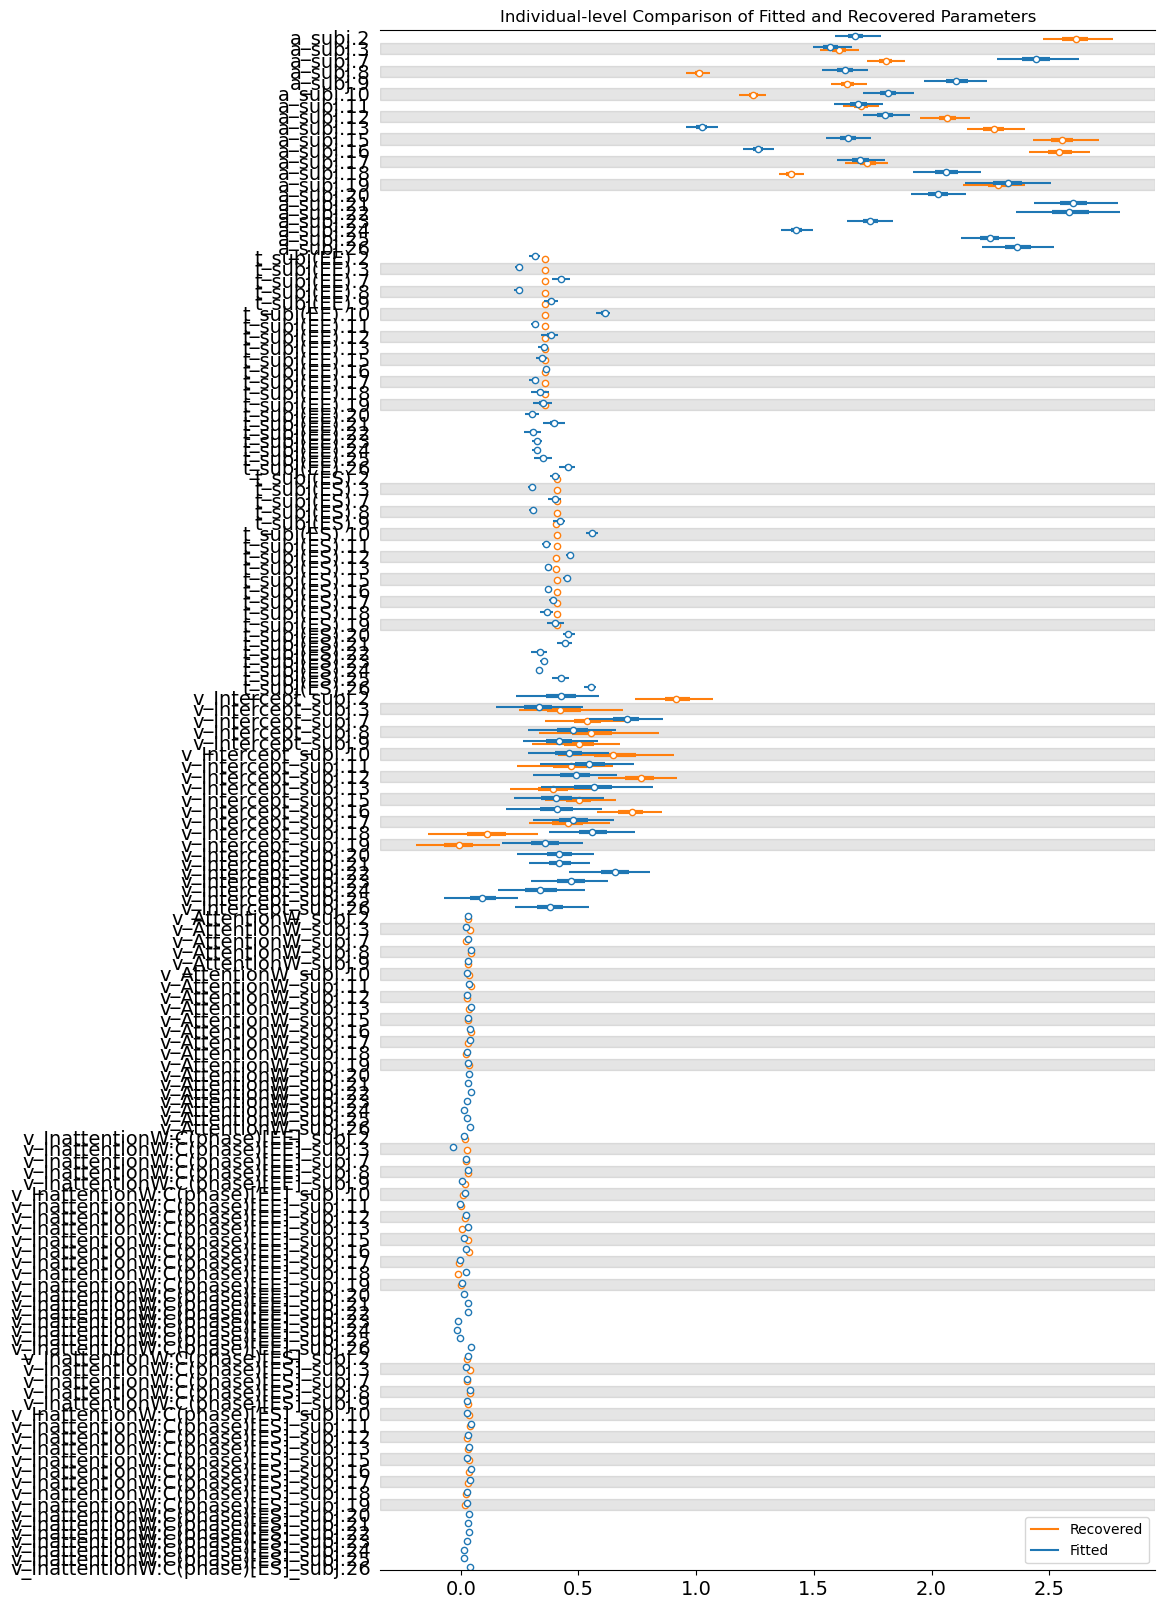

In [ ]:
# Subject level forest plot
ind_param_list = [param for param in esee5_infdata.posterior.data_vars if 'subj' in param and 'std' not in param]
fig, ax = plt.subplots(figsize=(10, 20))
az.plot_forest(
    [esee5_infdata, m_recovery_infdata],
    model_names=["Fitted", "Recovered"],
    var_names=ind_param_list,
    combined=True,
    ridgeplot_alpha=0.5,
    hdi_prob=0.95,
    ax=ax
)
ax.set_title("Individual-level Comparison of Fitted and Recovered Parameters")
plt.show()